In [1]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import random_split
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.manifold import TSNE
import numpy as np

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Define data transformations for training
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define data transformations for validation and test
transform_valid_test = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define dataset paths
dataset_dir='/content/drive/MyDrive/Datasets/Dataset_1'

# Load the dataset using ImageFolder
dataset = torchvision.datasets.ImageFolder(dataset_dir)

# Print the number of classes and their names
print(f"The number of classes is: {len(dataset.classes)}")
print(f"The classes are: {dataset.classes}")

The number of classes is: 6
The classes are: ['potato_early', 'potato_healthy', 'potato_late', 'tomato_early', 'tomato_healthy', 'tomato_late']


In [4]:
# Define the size of the training, validation, and test sets
train_size = int(0.7 * len(dataset))
valid_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - valid_size

# Split the dataset into training, validation, and test sets
train_dataset, valid_dataset, test_dataset = random_split(dataset, [train_size, valid_size, test_size])

# Apply the transformations to the datasets
train_dataset.dataset.transform = transform_train
valid_dataset.dataset.transform = transform_valid_test
test_dataset.dataset.transform = transform_valid_test

# Print the sizes of the training, validation, and test sets
print(f"Training dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

Training dataset size: 10269
Validation dataset size: 1467
Test dataset size: 2935


In [5]:
# Define data loaders for training, validation, and test sets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# Check if CUDA is available and set the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize MobileNetV3 model and move it to the device
model = models.mobilenet_v3_large(weights=None)
model = model.to(device)

# Define loss function
criterion = torch.nn.CrossEntropyLoss()

# Initialize Adam optimizer
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=0.0001)

Using device: cuda:0


In [6]:
# Lists to store metrics
train_accuracy_history = []
valid_accuracy_history = []
train_loss_history = []
valid_loss_history = []

# Train the model
num_epochs = 15
for epoch in range(num_epochs):
    # Training loop
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_train = []
    predicted_labels_train = []
    for inputs, labels in train_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop and optimization
        loss.backward()
        optimizer.step()

        # Compute training accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_train.extend(labels.cpu().numpy())
        predicted_labels_train.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    # Calculate training accuracy and loss
    epoch_train_accuracy = 100 * correct / total
    epoch_train_loss = running_loss / len(train_dataset)
    train_accuracy_history.append(epoch_train_accuracy)
    train_loss_history.append(epoch_train_loss)

    # Validation loop
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    true_labels_valid = []
    predicted_labels_valid = []
    for inputs, labels in valid_loader:
        # Forward pass
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Compute validation accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        true_labels_valid.extend(labels.cpu().numpy())
        predicted_labels_valid.extend(predicted.cpu().numpy())
        running_loss += loss.item() * inputs.size(0)

    # Calculate validation accuracy and loss
    epoch_valid_accuracy = 100 * correct / total
    epoch_valid_loss = running_loss / len(valid_dataset)
    valid_accuracy_history.append(epoch_valid_accuracy)
    valid_loss_history.append(epoch_valid_loss)

    # Print the training and validation metrics for the current epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Train Accuracy: {epoch_train_accuracy:.2f}%, Train Loss: {epoch_train_loss:.4f}, Valid Accuracy: {epoch_valid_accuracy:.2f}%, Valid Loss: {epoch_valid_loss:.4f}')

Epoch [1/15], Train Accuracy: 51.17%, Train Loss: 1.4546, Valid Accuracy: 17.11%, Valid Loss: 2.1278
Epoch [2/15], Train Accuracy: 75.19%, Train Loss: 0.6759, Valid Accuracy: 64.35%, Valid Loss: 0.9014
Epoch [3/15], Train Accuracy: 81.55%, Train Loss: 0.5137, Valid Accuracy: 84.59%, Valid Loss: 0.4690
Epoch [4/15], Train Accuracy: 85.35%, Train Loss: 0.4110, Valid Accuracy: 81.87%, Valid Loss: 0.5933
Epoch [5/15], Train Accuracy: 88.31%, Train Loss: 0.3457, Valid Accuracy: 90.32%, Valid Loss: 0.3013
Epoch [6/15], Train Accuracy: 90.13%, Train Loss: 0.2880, Valid Accuracy: 88.00%, Valid Loss: 0.3736
Epoch [7/15], Train Accuracy: 90.23%, Train Loss: 0.2792, Valid Accuracy: 88.62%, Valid Loss: 0.3202
Epoch [8/15], Train Accuracy: 91.89%, Train Loss: 0.2424, Valid Accuracy: 91.00%, Valid Loss: 0.2814
Epoch [9/15], Train Accuracy: 92.57%, Train Loss: 0.2174, Valid Accuracy: 92.71%, Valid Loss: 0.2128
Epoch [10/15], Train Accuracy: 92.69%, Train Loss: 0.2184, Valid Accuracy: 92.30%, Valid Lo

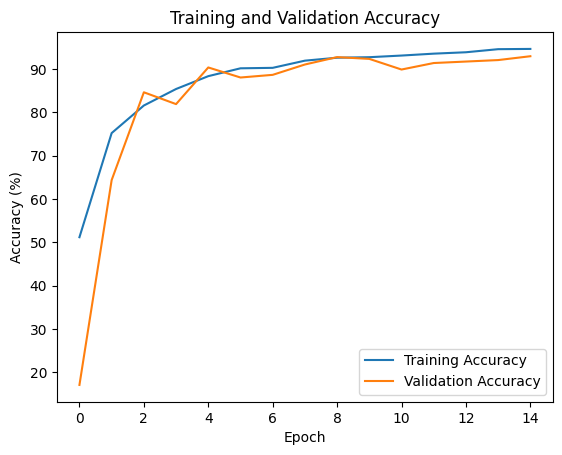

In [7]:
# Plot training and validation accuracy
plt.plot(train_accuracy_history, label='Training Accuracy')
plt.plot(valid_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

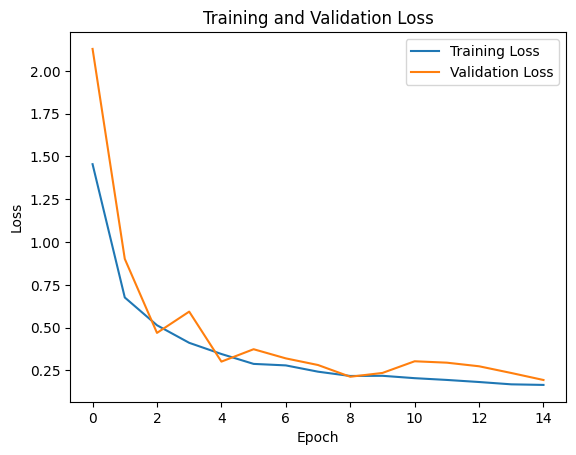

In [8]:
# Plot training and validation loss
plt.plot(train_loss_history, label='Training Loss')
plt.plot(valid_loss_history, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [9]:
# Generate classification report for training data
train_classification_report = classification_report(true_labels_train, predicted_labels_train, zero_division=0)

# Print training classification report
print("Training Classification Report:")
print(train_classification_report)

Training Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1729
           1       0.97      0.98      0.97      1592
           2       0.91      0.92      0.92      1707
           3       0.93      0.93      0.93      1685
           4       0.97      0.98      0.98      1720
           5       0.92      0.91      0.91      1836

    accuracy                           0.95     10269
   macro avg       0.95      0.95      0.95     10269
weighted avg       0.95      0.95      0.95     10269



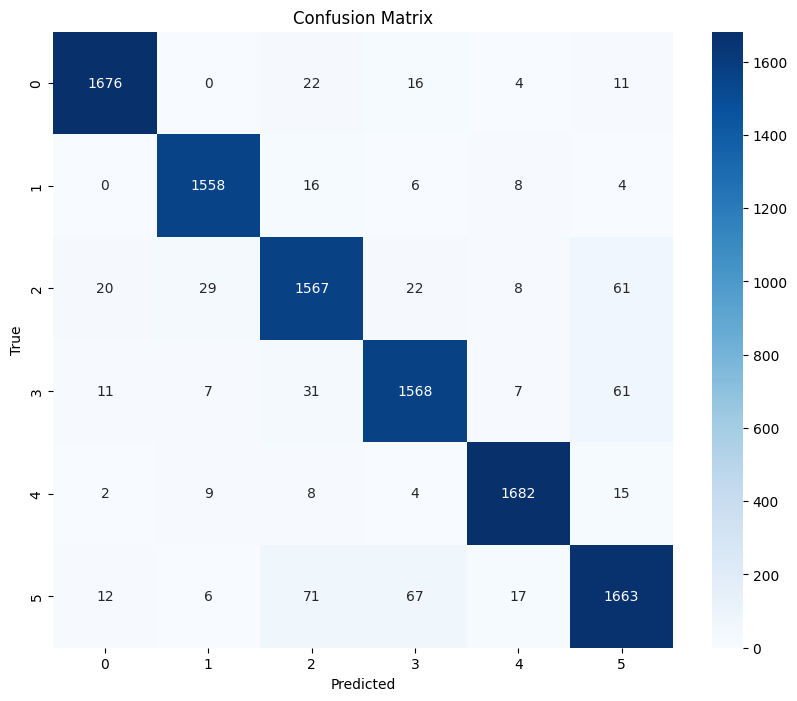

In [10]:
# Generate confusion matrix for training data
train_confusion_matrix = confusion_matrix(true_labels_train, predicted_labels_train)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(train_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [11]:
# Generate classification report for validation data
valid_classification_report = classification_report(true_labels_valid, predicted_labels_valid, zero_division=0)

# Print validation classification report
print("Validation Classification Report:")
print(valid_classification_report)

Validation Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.93      0.96       245
           1       0.96      0.99      0.97       228
           2       0.87      0.92      0.90       251
           3       0.88      0.97      0.93       254
           4       0.93      1.00      0.96       220
           5       0.97      0.78      0.87       269

    accuracy                           0.93      1467
   macro avg       0.93      0.93      0.93      1467
weighted avg       0.93      0.93      0.93      1467



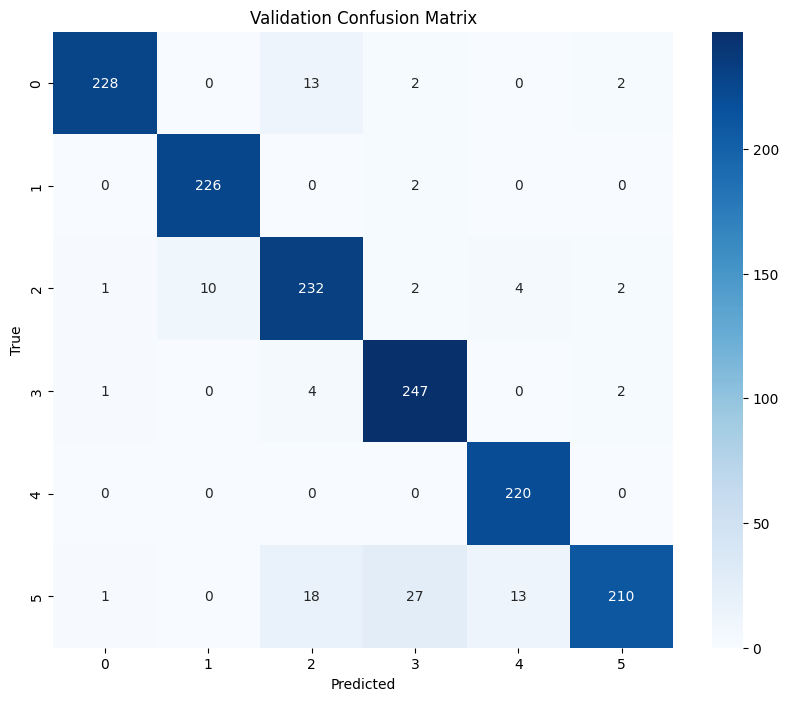

In [12]:
# Generate confusion matrix for validation data
valid_confusion_matrix = confusion_matrix(true_labels_valid, predicted_labels_valid)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(valid_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Validation Confusion Matrix')
plt.show()

In [13]:
# Save the trained model
torch.save(model.state_dict(), "/content/drive/MyDrive/Concordia University/Winter 2024/Applied Artificial Intelligence/Project/Saved Models/mobilenet_model_1.pth")

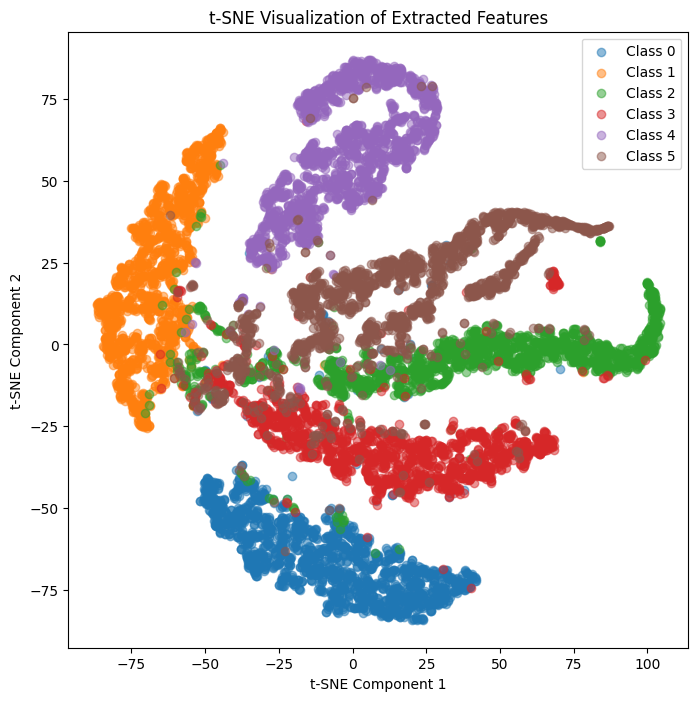

In [14]:
# Extract features from the trained model for the training dataset
train_features = []
train_labels = []
with torch.no_grad():
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        train_features.extend(outputs.cpu().numpy())
        train_labels.extend(labels.cpu().numpy())

# Convert train_features to a numpy array
train_features = np.array(train_features)

# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
train_features_tsne = tsne.fit_transform(train_features)

# Plot t-SNE visualization
plt.figure(figsize=(8, 8))
for class_idx in range(len(train_dataset.dataset.classes)):
    plt.scatter(train_features_tsne[np.array(train_labels) == class_idx, 0],
                train_features_tsne[np.array(train_labels) == class_idx, 1],
                label=f'Class {class_idx}', alpha=0.5)
plt.title('t-SNE Visualization of Extracted Features')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.show()

In [15]:
# Initialize lists to store true and predicted labels for the test set
true_labels_test = []
predicted_labels_test = []

# Evaluate the model on the test set
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        true_labels_test.extend(labels.tolist())
        predicted_labels_test.extend(predicted.tolist())

# Calculate the accuracy on the test set
accuracy = accuracy_score(true_labels_test, predicted_labels_test)
print(f"Testing Accuracy: {accuracy}")

Testing Accuracy: 0.941396933560477


In [16]:
# Generate classification report for test data
test_classification_report = classification_report(true_labels_test, predicted_labels_test, zero_division=0)

# Print test classification report
print("Test Classification Report:")
print(test_classification_report)

Test Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       466
           1       0.96      0.99      0.98       439
           2       0.89      0.92      0.91       482
           3       0.88      0.97      0.92       501
           4       0.96      1.00      0.98       505
           5       0.99      0.86      0.92       542

    accuracy                           0.94      2935
   macro avg       0.94      0.94      0.94      2935
weighted avg       0.94      0.94      0.94      2935



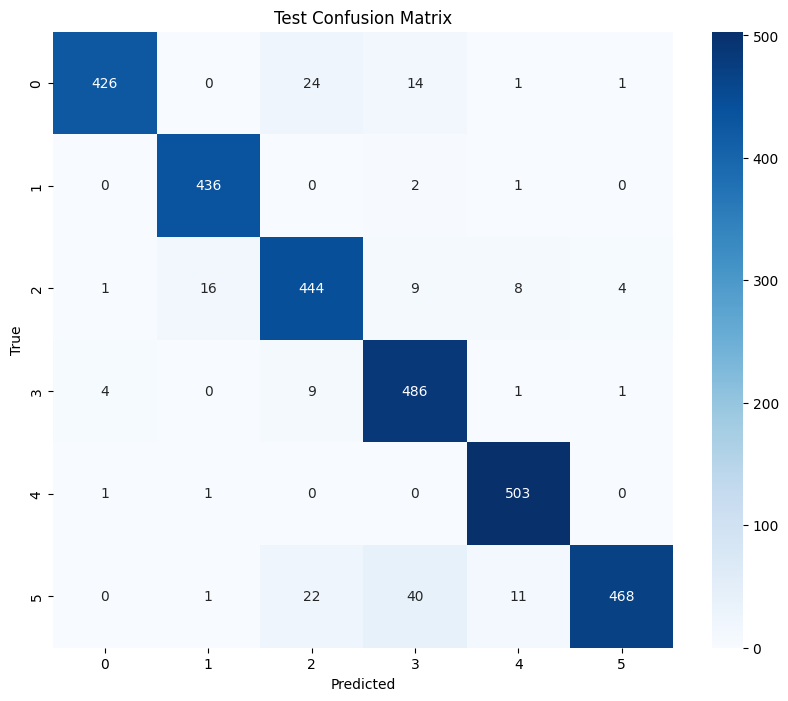

In [17]:
# Generate confusion matrix for test data
test_confusion_matrix = confusion_matrix(true_labels_test, predicted_labels_test)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(test_confusion_matrix, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Confusion Matrix')
plt.show()